# Frozen Lake - random walk

In [1]:
import gym
import pygame
import time

# pygame init
pygame.init()

# FrozenLake8x8 init
env = gym.make("FrozenLake-v1", desc=[
    "SFFFFFFF",
    "FFFFFFFF",
    "FFFHFFFF",
    "FFFFFHFF",
    "FFFHFFFF",
    "FHHFFFHF",
    "FHFFHFHF",
    "FFFHFFFG",
], is_slippery=True, render_mode="human")

env.reset()
env.render()  # First state

# random walk simulation
done = False
while not done:
    action = env.action_space.sample()  
    _, _, done, _, _ = env.step(action)  # step forward
    env.render()  
    time.sleep(0.5)

env.close()
pygame.quit()


/Users/janpoglod/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


: 

# Optimal policy walk

In [1]:
import gym
import numpy as np

import pygame
#pygame.init()
#pygame.display.init()
#pygame.display.list_modes()

# We will load a DiscreteEnv and retrieve the probability and reward information
env = gym.make("FrozenLake8x8-v1", desc=None, map_name=None, is_slippery=True, render_mode="human")
#env.reset()
#env.render() 

# first, we initialize the structures with zeros
prob = {i: {j: {a: 0 for a in range(env.action_space.n)}
            for j in range(env.observation_space.n)}
        for i in range(env.observation_space.n)}
rewd = {i: {j: {a: 0 for a in range(env.action_space.n)}
            for j in range(env.observation_space.n)}
        for i in range(env.observation_space.n)}
# then, we fill them with the actual information
for i in range(env.observation_space.n):
    for a in range(env.action_space.n):
        for (p, j, r, d) in env.P[i][a]:
            prob[i][j][a] += p
            rewd[i][j][a] += r

####################
# Policy computation
####################
"""
T = 100 
policy = {t: {i: env.action_space.sample()
              for i in range(env.observation_space.n)}
          for t in range(T)}
"""

# ___ Policy creation: ___
gamma = 0.9  # discount
theta = 1e-5  # convergence threshold
T = 100  # finite horizon for policy

# State Values init
V = np.zeros(env.observation_space.n)

for _ in range(1000):  
    delta = 0
    for s in range(env.observation_space.n):
        v = V[s]
        # calculating value for each action and choose best - Q_values
        Q_values = []
        for a in range(env.action_space.n):
            q = 0
            for (p, next_state, reward, done) in env.P[s][a]:
                q += p * (reward + gamma * V[next_state])
            Q_values.append(q)
        # update of state value for best Q
        V[s] = max(Q_values)
        delta = max(delta, abs(v - V[s]))
    # convergence check
    if delta < theta:
        break

# Creating policy relalated do the state values V
policy = {t: {} for t in range(T)}
for s in range(env.observation_space.n):
    # looking for best action (related to Q value) 
    best_action = None
    best_value = float('-inf')
    for a in range(env.action_space.n):
        q = sum(p * (reward + gamma * V[next_state])
                for (p, next_state, reward, done) in env.P[s][a])
        if q > best_value:
            best_value = q
            best_action = a
    # take best policy for every time step
    for t in range(T):
        policy[t][s] = best_action


# ___ Policy evaluation: ___
def evaluate_policy(env, policy, T, gamma):
    nS = env.observation_space.n
    V = np.zeros(nS)
    
    for t in range(T):
        V_new = np.zeros(nS)
        for s in range(nS):
            a = policy[t][s]  # taking action from policy for current state and time step
            V_new[s] = sum(p * (reward + gamma * V[next_state])
                           for (p, next_state, reward, done) in env.P[s][a])
        V = V_new
    
    return np.sum(V) # expected value return

# evaluate for optimal
optimal_value = evaluate_policy(env, policy, T, gamma)
print("Expected total reward for the optimal policy:", optimal_value)

# evaluate for random
random_policy = {t: {i: env.action_space.sample()
              for i in range(env.observation_space.n)}
          for t in range(T)}
random_value = evaluate_policy(env, random_policy, T, gamma)
print("Expected total reward for the random policy:", random_value)

############# POLICY EVAL FOR RANDOM POLICY ####################################
#compute the transition matrix
transition_matrix = np.zeros((T,env.observation_space.n,env.observation_space.n))
for time in range(T):
  for i in range(env.observation_space.n):
    for j in range(env.observation_space.n):
      transition_matrix[time,i,j] = prob[i][j][random_policy[time][i]]  #it's a deterministic policy

#compute the reward vectors
reward_vector = np.zeros((T,env.observation_space.n))
for time in range(T):
  for i in range(env.observation_space.n):
    # because the rewards are stochastic: reward_vector[time][state] = Expected reward at time t in by taking the action defined by the policy in state i
    reward_vector[time,i] = sum(rewd[i][j][random_policy[time][i]] * prob[i][j][random_policy[time][i]] for j in range(env.observation_space.n))

random_value = np.zeros((env.observation_space.n))

for time in range(T):
  prod = transition_matrix[0,:,:]
  if time > 0:
    for t in range(1, time):
      prod = prod @ transition_matrix[t,:,:]
  prod = prod @ reward_vector[time,:]
  random_value += prod
################################################################################
############# POLICY EVAL FOR optimal POLICY ###################################
#compute the transition matrix
transition_matrix_optimal = np.zeros((T,env.observation_space.n,env.observation_space.n))
for time in range(T):
  for i in range(env.observation_space.n):
    for j in range(env.observation_space.n):
      transition_matrix_optimal[time,i,j] = prob[i][j][policy[time][i]]  #it's a deterministic policy

#compute the reward vectors
reward_vector_optimal = np.zeros((T,env.observation_space.n))
for time in range(T):
  for i in range(env.observation_space.n):
    # because the rewards are stochastic: reward_vector[time][state] = Expected reward at time t in by taking the action defined by the policy in state i
    reward_vector_optimal[time,i] = sum(rewd[i][j][policy[time][i]] * prob[i][j][policy[time][i]] for j in range(env.observation_space.n))

value = np.zeros((env.observation_space.n))

for time in range(T):
  prod = transition_matrix_optimal[0,:,:]
  if time > 0:
    for t in range(1, time):
      prod = prod @ transition_matrix_optimal[t,:,:]
  prod = prod @ reward_vector_optimal[time,:]
  value += prod

################################################################################

# Simulation: you can try your policy here
state,_ = env.reset()
for t in range(T):
    #env.render()
    action = policy[t][state]
    print(state)
    print(f"Action = {action}")
    state, reward, done, _, _ = env.step(action)
    # if the MDP is stuck, we end the simulation here
    if done:
        print(state)
        print(f"Episode finished after {t + 1} timesteps")
        break
env.close()

"""
# Simulation: you can try your policy here
state = env.reset()
for i, t in enumerate(range(T)):
    #env.render()
    if i ==0:
        action = policy[t][state[0]]
        print(f"Action = {action}")
        state, reward, done, _, _ = env.step(action)
        #print(state, reward, done)
    else:
        action = policy[t][state]
        print(f"Action = {action}")
        state, reward, done, _, _ = env.step(action)

    # if the MDP is stuck, we end the simulation here
    if done:
        print(f"Episode finished after {t + 1} timesteps")
        break
env.close()
pygame.quit()
"""

Expected total reward for the optimal policy: 9.281640893448856
Expected total reward for the random policy: 2.7288910248020475
0
Action = 1


/Users/janpoglod/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0
Action = 1
1
Action = 2
2
Action = 2
10
Action = 1
11
Action = 3
3
Action = 2
11
Action = 3
12
Action = 2
13
Action = 1
14
Action = 1
22
Action = 2
23
Action = 1
31
Action = 1
31
Action = 1
30
Action = 1
38
Action = 1
39
Action = 1
39
Action = 1
47
Action = 1
46
Action = 1
47
Action = 1
47
Action = 1
47
Action = 1
46
Action = 1
45
Action = 1
53
Action = 2
54
Action = 1
62
Action = 2
63
Episode finished after 29 timesteps


'\n# Simulation: you can try your policy here\nstate = env.reset()\nfor i, t in enumerate(range(T)):\n    #env.render()\n    if i ==0:\n        action = policy[t][state[0]]\n        print(f"Action = {action}")\n        state, reward, done, _, _ = env.step(action)\n        #print(state, reward, done)\n    else:\n        action = policy[t][state]\n        print(f"Action = {action}")\n        state, reward, done, _, _ = env.step(action)\n\n    # if the MDP is stuck, we end the simulation here\n    if done:\n        print(f"Episode finished after {t + 1} timesteps")\n        break\nenv.close()\npygame.quit()\n'

: 

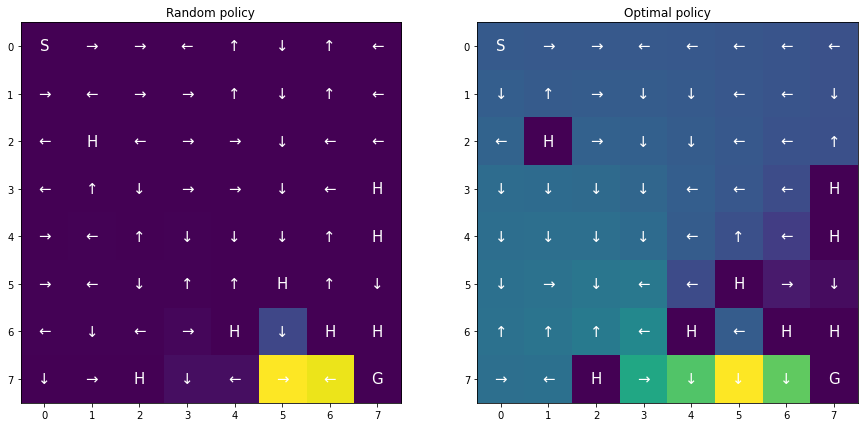

: 

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(15,10))
moves_to_str = {
            3: u'↑',
            2: u'→',
            1: u'↓',
            0: u'←',
            }

## RANDOM POLICY
actions = np.array([random_policy[0][i] for i in range(env.observation_space.n)]).reshape((8,8))
axs[0].set_title('Random policy')
axs[0].imshow(random_value.reshape((8,8)))
## OPTIMAL POLICY
actions_optimal = np.array([policy[0][i] for i in range(env.observation_space.n)]).reshape((8,8))
axs[1].set_title('Optimal policy')
axs[1].imshow(value.reshape((8,8)))


# random policy:
for i in range(8):
  for j in range(8):
      t = moves_to_str[actions[i,j]]
      if env.desc[i,j] == b'H':
        text = axs[0].text(j, i, 'H',
                      ha="center", va="center", color="w", fontsize=15)
      elif env.desc[i,j] == b'S':
        text = axs[0].text(j, i, 'S',
                      ha="center", va="center", color="w", fontsize=15)
      elif env.desc[i,j] == b'G':
        text = axs[0].text(j, i, 'G',
                      ha="center", va="center", color="w", fontsize=15)
      else:
        text = axs[0].text(j, i, t,
                        ha="center", va="center", color="w", fontsize=15)
# optimal policy:
for i in range(8):
  for j in range(8):
      t = moves_to_str[actions_optimal[i,j]]
      if env.desc[i,j] == b'H':
        text = axs[1].text(j, i, 'H',
                      ha="center", va="center", color="w", fontsize=15)
      elif env.desc[i,j] == b'S':
        text = axs[1].text(j, i, 'S',
                      ha="center", va="center", color="w", fontsize=15)
      elif env.desc[i,j] == b'G':
        text = axs[1].text(j, i, 'G',
                      ha="center", va="center", color="w", fontsize=15)
      else:
        text = axs[1].text(j, i, t,
                        ha="center", va="center", color="w", fontsize=15)
plt.show()